# Recurrent Neural Network for Stock Price Prediction


In [1]:
import pandas as pd
import pandas_datareader.data as web
import datetime

start = datetime.datetime(2017, 1, 1)
end = datetime.date.today()

# Read the stock data for Apple
apple = web.DataReader('AAPL', 'morningstar', start, end)

In [2]:
apple.head()

Close      High     Low    Open    Volume
Symbol Date                                                  
AAPL   2017-01-02  115.82  115.8200  115.82  115.82         0
       2017-01-03  116.15  116.3300  114.76  115.80  28781865
       2017-01-04  116.02  116.5100  115.75  115.85  21118116
       2017-01-05  116.61  116.8642  115.81  115.92  22193587
       2017-01-06  117.91  118.1600  116.47  116.78  31751900

In [3]:
# Drop Rows which have Volume=0
apple = apple[apple.Volume != 0]
apple.head()

Close      High     Low    Open    Volume
Symbol Date                                                  
AAPL   2017-01-03  116.15  116.3300  114.76  115.80  28781865
       2017-01-04  116.02  116.5100  115.75  115.85  21118116
       2017-01-05  116.61  116.8642  115.81  115.92  22193587
       2017-01-06  117.91  118.1600  116.47  116.78  31751900
       2017-01-09  118.99  119.4300  117.94  117.95  33561948

In [4]:
# We are going to use only the close price
close = apple.as_matrix(columns={'Close'})
print(close[:5])

[[ 116.15]
 [ 116.02]
 [ 116.61]
 [ 117.91]
 [ 118.99]]


In [11]:
import tensorflow as tf
import numpy as np

tf.reset_default_graph()

n_steps = 20
n_inputs = 1
n_neurons = 100
n_outputs = 1

X = tf.placeholder(tf.float32, [None, n_steps, n_inputs])
y = tf.placeholder(tf.float32, [None, n_steps, n_outputs])

rnn_cell = tf.contrib.rnn.BasicRNNCell(num_units=n_neurons, activation=tf.nn.relu)
wrapper = tf.contrib.rnn.OutputProjectionWrapper(rnn_cell, output_size=n_outputs)
outputs, states = tf.nn.dynamic_rnn(wrapper, X, dtype=tf.float32)

learning_rate = 0.001

loss = tf.reduce_mean(tf.square(outputs - y))
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
training_op = optimizer.minimize(loss)

init = tf.global_variables_initializer()

In [12]:
target = np.roll(close, -1)
print(target[:5])

[[ 116.02]
 [ 116.61]
 [ 117.91]
 [ 118.99]
 [ 119.11]]


In [22]:
input_batches = []
target_batches = []

# Create mini batches
number_of_batches = len(close) // n_steps
for index in range(0, number_of_batches * n_steps, number_of_batches):
    input_batches.append(close[index:index+n_steps])
    target_batches.append(target[index:index+n_steps])

In [30]:
n_iterations = 100000
batch_size = 50

saver = tf.train.Saver()

with tf.Session() as sess:
    init.run()
    for iteration in range(n_iterations):
        X_batch, y_batch = input_batches, target_batches
        sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        if iteration % 1000 == 0:
            mse = loss.eval(feed_dict={X: X_batch, y: y_batch})
            print(iteration, '\tMSE:', mse)
            
    saver.save(sess, "./checkpoints/model")

0 	MSE: 8943.48
1000 	MSE: 4.06036
2000 	MSE: 3.72489
3000 	MSE: 3.03123
4000 	MSE: 2.8745
5000 	MSE: 2.76723
6000 	MSE: 2.49549
7000 	MSE: 2.3575
8000 	MSE: 2.37196
9000 	MSE: 2.03622
10000 	MSE: 2.14894
11000 	MSE: 2.00528
12000 	MSE: 1.81256
13000 	MSE: 1.99272
14000 	MSE: 1.64617
15000 	MSE: 1.58467
16000 	MSE: 1.55382
17000 	MSE: 1.45396
18000 	MSE: 1.49096
19000 	MSE: 1.35911
20000 	MSE: 1.58131
21000 	MSE: 1.34705
22000 	MSE: 1.32284
23000 	MSE: 1.22176
24000 	MSE: 1.21376
25000 	MSE: 1.15275
26000 	MSE: 1.53072
27000 	MSE: 1.15676
28000 	MSE: 1.0853
29000 	MSE: 1.0841
30000 	MSE: 1.57891
31000 	MSE: 1.20809
32000 	MSE: 1.0868
33000 	MSE: 1.18509
34000 	MSE: 1.04695
35000 	MSE: 1.01517
36000 	MSE: 0.955781
37000 	MSE: 0.936446
38000 	MSE: 0.93772
39000 	MSE: 0.904414
40000 	MSE: 0.945975
41000 	MSE: 0.890679
42000 	MSE: 0.868857
43000 	MSE: 0.854086
44000 	MSE: 0.903718
45000 	MSE: 0.908915
46000 	MSE: 0.943158
47000 	MSE: 1.02315
48000 	MSE: 0.838597
49000 	MSE: 0.868442
50000 

In [31]:
last_20_days = close[-20:]
print(last_20_days)

[[ 168.38]
 [ 170.05]
 [ 173.25]
 [ 172.44]
 [ 174.14]
 [ 174.73]
 [ 175.82]
 [ 178.24]
 [ 177.84]
 [ 172.8 ]
 [ 165.72]
 [ 165.24]
 [ 162.94]
 [ 163.65]
 [ 164.22]
 [ 162.32]
 [ 165.26]
 [ 169.1 ]
 [ 176.57]
 [ 176.89]]


In [32]:
# Use the RNN to predict the stock price
with tf.Session() as sess:
    saver.restore(sess, "./checkpoints/model")
    y_pred = sess.run(outputs, feed_dict={X: [last_20_days]})

y_pred = y_pred.flatten()
print(y_pred)

[ 168.01113892  170.17652893  172.03794861  171.21899414  178.40826416
  172.67782593  171.6645813   181.68066406  178.75254822  168.13908386
  165.53318787  163.20724487  169.33084106  158.42385864  164.8168335
  160.72160339  169.52362061  174.09469604  171.31887817  180.17338562]


In [33]:
target_incl_current = np.append(last_20_days[1:], 178.9)
print(target_incl_current)

[ 170.05  173.25  172.44  174.14  174.73  175.82  178.24  177.84  172.8
  165.72  165.24  162.94  163.65  164.22  162.32  165.26  169.1   176.57
  176.89  178.9 ]


In [34]:
error = target_incl_current - y_pred
print(error)

[ 2.03886108  3.07347107  0.40205139  2.92100586 -3.67826416  3.14217407
  6.5754187  -3.84066406 -5.95254822 -2.41908386 -0.29318787 -0.26724487
 -5.68084106  5.79614136 -2.4968335   4.53839661 -0.42362061  2.47530396
  5.57112183 -1.27338562]


In [35]:
# Create Labels for the X axis
x_labels = []

for element in apple.index.get_values()[-19:]:
    x_labels.append(element[1].date().strftime('%d/%m'))

# Add the last day
x_labels.append(datetime.date(2018, 5, 4).strftime('%d/%m'))
    
print(x_labels)

['09/04', '10/04', '11/04', '12/04', '13/04', '16/04', '17/04', '18/04', '19/04', '20/04', '23/04', '24/04', '25/04', '26/04', '27/04', '30/04', '01/05', '02/05', '03/05', '04/05']


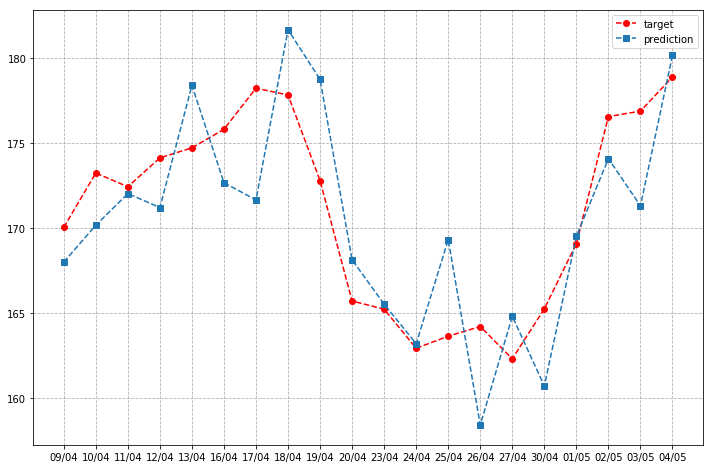

In [36]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,8))

plt.plot(x_labels, target_incl_current, 'ro', label='target', linestyle='dashed')
plt.plot(x_labels, y_pred, 's', label='prediction', linestyle='dashed')
plt.legend()

plt.grid(b=True, linestyle='--')

plt.show()